# Surface observation postprocessing 


In these notebooks we try some machine learning techniques on a real world simple problem.

We are trying to improve the ECMWF forecast of surface temperature, by doing postprocessing. 

Specifically, we are trying to predict the difference between station observations 2m-temperature and the forecast prediction at the nearest gridpoint to the observation location. This is a regression task.

If we can accurately predict this difference (the forecast error) we can compensate for it, making the forecast more accurate.

We will explore several physically motivated predictors.

Note this example of using machine learning to model weather forecast error based on work by Fenwick Cooper funded by <a href="https://www.ifabfoundation.org/">IFAB</a>, the full study can be found <a href="https://www.ecmwf.int/en/elibrary/81297-statistical-modelling-2m-temperature-and-10m-wind-speed-forecast-errors">here</a>.

<style>
td, th {
   border: 1px solid white;
   border-collapse: collapse;
}
</style>
<table align="left">
  <tr>
    <th>Run the tutorial via free cloud platforms: </th>
    <th><a href="https://colab.research.google.com/github/ecmwf-projects/mooc-machine-learning-weather-climate/blob/main/tier_2/regression_decision_trees/linear_regression.ipynb">
        <img src = "https://colab.research.google.com/assets/colab-badge.svg" alt = "Colab"></th>
    <th><a href="https://deepnote.com/launch?url=https://github.com/ecmwf-projects/mooc-machine-learning-weather-climate/blob/main/tier_2/regression_decision_trees/linear_regression.ipynb">
        <img src = "https://deepnote.com/buttons/launch-in-deepnote-small.svg" alt = "Kaggle"></th>
  </tr>
</table>

## Using linear regression (with nonlinear features)

Linear regression can be a powerful tool for model building. Even in cases where it does not produce the most accurate model, it is easy to interprete the decisions it has made.

Here we use linear regression of nonlinear features to model the problem. We still solve a least-squares problem to find the best fitting linear model, but we include powers of the predictors as inputs.
e.g. instead of building y = a + b*x we can learn y = a + b * x + c * x^2

The choice of which powers or combinations of features to use could be motivated by physical understanding of the problem. 

In [1]:
# Install the package for our dataset
# this can take a few minutes the first time you run it.
!pip install "climetlab-mltc-surface-observation-postprocessing>=0.3.0" --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.6/158.6 KB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 37.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 27.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.4/74.4 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 113.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  

In [2]:
# First import the tools we will use. Where possible it is always worth using
# existing tools, even if the mathematics are simple to write down yourself.
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
import matplotlib.pyplot as plt

# Import a tool for helping make figures
from climetlab_mltc_surface_observation_postprocessing.utils import imgBufferFromVectors

# CliMetLab will be used to manage the data loading.
import climetlab as cml

In [3]:
# Load a list of 36 hour forecast errors for 2m temperature.
# The forecasts come from ECMWF's high resolution forecast system.
# The measurements come from around 8000 weather stations around the world.
forecast_error = cml.load_dataset('mltc-surface-observation-postprocessing',field='forecast_error').to_numpy()

# We suspect that the errors in the forecast can be explained simply by the time of day.

# Load the local time of day corresponding to when the measurements were made.
time_of_day = cml.load_dataset('mltc-surface-observation-postprocessing',field='time_of_day').to_numpy()

# Later we will add in the soil temperature
soil_temperature = cml.load_dataset('mltc-surface-observation-postprocessing',field='soil_temperature').to_numpy()

# Note that an important step of data preprocessing has already been carried out in the curation of the dataset.
# Spurious data has already been removed from the dataset based upon a range of categories,
# e.g. stations with inconsistent measurement locations, repeated values, or even physically 
# invalid numbers (>100C).
# If you are starting on a new project this is a key step to clean the data.

By downloading data from this dataset, you agree to the terms and conditions defined at https://github.com/mchantry/climetlab-mltc-sop/blob/main/LICENSE. If you do not agree with such terms, do not download the data. 


forecast_error.csv:   0%|          | 0.00/88.3M [00:00<?, ?B/s]

time_of_day.csv:   0%|          | 0.00/92.9M [00:00<?, ?B/s]

soil_temperature.csv:   0%|          | 0.00/87.8M [00:00<?, ?B/s]

In [4]:
# Split each of the predictands and predictors in a random train/test split.
# We use 80% of the data for training & 20% for testing

# Here the data has already been anonymised, so we cannot use information about
# stations or time to ensure independence of our dataset.
# With more meta-data we should follow the lessons learnt in tier-2 on data splitting
# and ensure the data subsets are independent

# We don't plan to explore hyperparameter space, so a validation set is not required.

(forecast_error_train, forecast_error_test, 
    time_of_day_train, time_of_day_test, 
    soil_temperature_train,  soil_temperature_test) = train_test_split(forecast_error, #the variables to split
                                                                       time_of_day,
                                                                       soil_temperature,
                                                                       test_size = 0.2, #what proportion of the data to use in the test set
                                                                       random_state = 42, #set the random seed for reproducibility
                                                                      )

In [5]:
%%time
# Find the line of best fit of a cubic polynomial using scikit-learn
# y = c0 + c1 * x + c2 * x^2 + c3 * x^3

# Create the predictor data
X = np.concatenate([time_of_day_train, time_of_day_train**2, time_of_day_train**3],axis=-1)

# Create linear regression object
reg = linear_model.LinearRegression()

# Note: The model is linear in the fit coefficients c0, c1, c2, and c3. This is the "linear"
#       in linear regression. Using linear regression we are fitting a cubic polynomial
#       function which is non-linear in x.

# Train the model using the data.
# We task it to find the best fit for the forecast errors given a cubic relationship.
reg.fit(X, forecast_error_train)

# Once complete, we can extract the coefficients from the regression model and 
# rename the coefficients found by the fit
c0 = reg.intercept_
c1 = reg.coef_[0][0]
c2 = reg.coef_[0][1]
c3 = reg.coef_[0][2]

# Make a line of best fit for plotting
x = np.linspace(0, 24, 49)
# Here we write the polynomial expression directly
y = c0 + c1 * x + c2 * x**2 + c3 * x**3
# or equivalently use the our regression object directly.
x_stack = np.stack([x,x**2,x**3],axis=-1)
y = reg.predict(x_stack)

CPU times: user 583 ms, sys: 344 ms, total: 927 ms
Wall time: 892 ms


In [6]:
# First let's evaluate our model, using root-mean-squared-error and mean-absolute-error

# To establish a baseline let's find out the RMSE and MAE of the existing predictions.
# Our baseline is no error correction, or a correction of 0.
zero_test = 0.0*forecast_error_test

baseline_mae = metrics.mean_absolute_error(zero_test, forecast_error_test)
baseline_rmse = np.sqrt(metrics.mean_squared_error(zero_test, forecast_error_test))
print('Mean Absolute Error Uncorrected:', baseline_mae)
print('Root Mean Squared Error Uncorrected:', baseline_rmse)


Mean Absolute Error Uncorrected: 1.6323756023379807
Root Mean Squared Error Uncorrected: 2.2561352539787456


In [7]:
# Build our input array, then make a prediction with our model
X_test = np.concatenate([time_of_day_test, time_of_day_test**2, time_of_day_test**3],axis=-1)

forecast_corrected = reg.predict(X_test)

corrected_mae = metrics.mean_absolute_error(forecast_error_test, forecast_corrected)
corrected_rmse = np.sqrt(metrics.mean_squared_error(forecast_error_test, forecast_corrected))

print('Mean Absolute Error Corrected:', corrected_mae)
print('Root Mean Squared Error Corrected:', corrected_rmse)

print('% Improvement MAE over raw forecast', -(corrected_mae - baseline_mae)/baseline_mae * 100 )
print('% Improvement RMSE over raw forecast', -(corrected_rmse - baseline_rmse)/baseline_rmse * 100 )


Mean Absolute Error Corrected: 1.5965240993023346
Root Mean Squared Error Corrected: 2.220606877395627
% Improvement MAE over raw forecast 2.196277804219663
% Improvement RMSE over raw forecast 1.5747449768564892


So we get 1-2% improvement from correcting a time of day dependent bias.

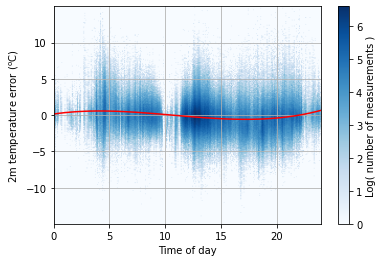

In [8]:
# Make an image of the time of day against the forecast error.
# This function helps us build an image of the results
tod_buffer, ax_extent, count = imgBufferFromVectors(time_of_day_test, forecast_error_test,
                                                    nx=256, ny=256, extent=[],
                                                    calc_average=False)
# Plot the number of measurements at each time of day and forecast error
plt.imshow(np.log((count==0.0)+count),
           cmap='Blues', origin='lower',
           extent=ax_extent, aspect='auto')

plt.xlim([0, 24])
plt.grid()
plt.xlabel('Time of day')
plt.ylabel('2m temperature error ($^\mathrm{o}$C)')
cb = plt.colorbar()
cb.set_label('Log( number of measurements )')

# Line of best fit
plt.plot(x,y,'red')

plt.show()

Note: The model (red line) is better than nothing, but cannot account for the variation in 2m temperature error at single time of day (eg. at 14:00).

You could use a neural network or other machine learning methods to find the red line instead, but no model can account for all of the 2m temperature error with only this single predictor.

How can we improve the results? Let's test whether another predictor can help. We will try using the soil temperature.

## Adding more predictors

Next we will add a second predictor, the model soil temperature.

Let's look at how the forecast error varies with these predictors to understand how well we might expect our model to perform.

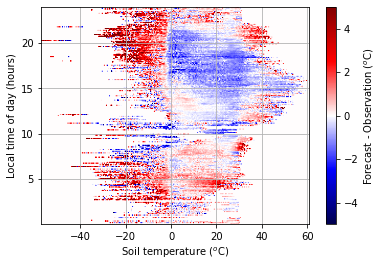

In [9]:
# Make image of the error with the new predictor
buffer, ax_extent, count = imgBufferFromVectors(soil_temperature_test,
                                                time_of_day_test,
                                                forecast_error_test,
                                                256, 256,
                                                extent = [],
                                                calc_average=True)
# Plot the image of the error
plt.imshow(buffer, vmin=-5, vmax=5, cmap='seismic', origin='lower',
           extent=ax_extent, aspect='auto')

plt.grid()
plt.xlabel('Soil temperature ($^o$C)')
plt.ylabel("Local time of day (hours)")
cb = plt.colorbar()
cb.set_label('Forecast - Observation ($^o$C)')

plt.show()

We see that forecast errors vary with both of these predictors, so we can expect our model to improve if we add soil temperature as a predictor.

In [10]:
# Let's write a function to concatenate all the polynomial terms up to power 3
# we'll then use it a few times to generate our training and testing arrays
def build_cubic_predictor_array(time_of_day,soil_temperature,soil_frozen):
  X = np.concatenate([
      # Linear terms
              time_of_day, soil_temperature, soil_frozen,
              # Quadratic terms
              time_of_day**2,
              time_of_day * soil_temperature,
              time_of_day * soil_frozen,
              soil_temperature**2,
              soil_temperature * soil_frozen,
              # soil_frozen**2 == 1, so we leave out
              # Cubic terms
              time_of_day**3,
              time_of_day**2 * soil_temperature,
              time_of_day**2 * soil_frozen,
              time_of_day    * soil_temperature**2,
              time_of_day    * soil_temperature * soil_frozen,
              soil_temperature**3,
              soil_temperature**2 * soil_frozen,
              ],axis=-1)
  return X


In [11]:
%%time 
# Fit a cubic polynomial using scikit-learn

# To help the model learn we will create an extra feature to highlight that 0C carries importance.

# Where the soil is frozen (1) or not (0)
soil_frozen_train = soil_temperature_train < 0.0

#Try removing this feature and rerunning the notebook to see if the prediction degrades.

# Create the data using a cubic polynomial.
# (Note that soil_frozen**2 == soil_frozen.)
X = build_cubic_predictor_array(time_of_day_train, soil_temperature_train, soil_frozen_train)

# Create linear regression object
reg = linear_model.LinearRegression()

# Train the model using the train sets
reg.fit(X, forecast_error_train)

CPU times: user 2.53 s, sys: 1.1 s, total: 3.63 s
Wall time: 3.1 s


LinearRegression()

In [12]:
# Calculate Root Mean Square error of predictions:

zero_test = 0.0*forecast_error_test
print('Mean Absolute Error Uncorrected:', metrics.mean_absolute_error(zero_test, forecast_error_test))
print('Root Mean Squared Error Uncorrected:', np.sqrt(metrics.mean_squared_error(zero_test, forecast_error_test)))

#Now apply forecast error correction:
soil_frozen_test = soil_temperature_test < 0.0      # Where the soil is frozen (1) or not (0)

X_test = build_cubic_predictor_array(time_of_day_test, soil_temperature_test, soil_frozen_test)

forecast_corrected = reg.predict(X_test)

##forecast_corrected = linear_model.predict(X_apply)
corrected_mae = metrics.mean_absolute_error(forecast_error_test, forecast_corrected)
corrected_rmse = np.sqrt(metrics.mean_squared_error(forecast_error_test, forecast_corrected))

print('Mean Absolute Error Corrected:', corrected_mae)
print('Root Mean Squared Error Corrected:', corrected_rmse)

print('% Improvement MAE over raw forecast', -(corrected_mae - baseline_mae)/baseline_mae * 100 )
print('% Improvement RMSE over raw forecast', -(corrected_rmse - baseline_rmse)/baseline_rmse * 100 )



Mean Absolute Error Uncorrected: 1.6323756023379807
Root Mean Squared Error Uncorrected: 2.2561352539787456
Mean Absolute Error Corrected: 1.5789160602216956
Root Mean Squared Error Corrected: 2.1904684192212827
% Improvement MAE over raw forecast 3.2749535119072677
% Improvement RMSE over raw forecast 2.9105894534318355


### We see a reduction of ~0.06C, or ~3% just from using these two predictors. 

### Let's visualise the results 

In [13]:
# Run the fit model over the plot domain

# The x and y values of each point in the plot image
nx = buffer.shape[0]
ny = buffer.shape[1]
x_st = np.linspace(ax_extent[0],ax_extent[1],nx)  # Represents soil_temperature
y_tod = np.linspace(ax_extent[2],ax_extent[3],ny)  # Represents time_of_day

# These lines 
x_mesh = np.meshgrid(y_tod,x_st,indexing='ij') 
tod_test = x_mesh[0].reshape((-1,1))
soil_test = x_mesh[1].reshape((-1,1))
frozen_test = soil_test < 0.0 

X_plot = build_cubic_predictor_array(tod_test,soil_test,frozen_test)

model_buffer = reg.predict(X_plot).reshape(buffer.shape)

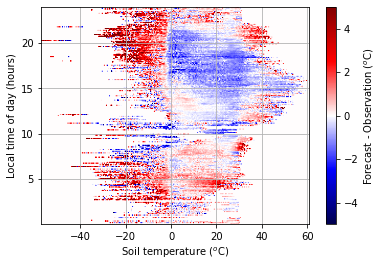

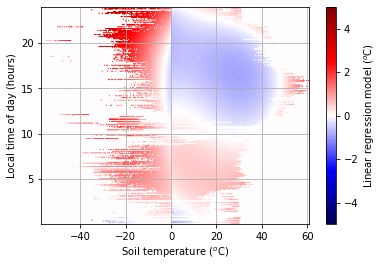

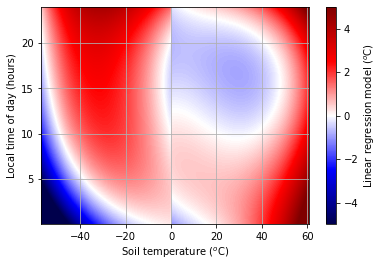

In [14]:
# Plot the image of the error
plt.imshow(buffer, vmin=-5, vmax=5, cmap='seismic', origin='lower',
           extent=ax_extent, aspect='auto')

plt.grid()
plt.xlabel('Soil temperature ($^o$C)')
plt.ylabel("Local time of day (hours)")
cb = plt.colorbar()
cb.set_label('Forecast - Observation ($^o$C)')

plt.show()

# Plot the model, only over the points where there is data in the test set.
plt.imshow((model_buffer)*(count>0), vmin=-5, vmax=5, cmap='seismic', origin='lower',
           extent=ax_extent, aspect='auto')

plt.grid()
plt.xlabel('Soil temperature ($^o$C)')
plt.ylabel("Local time of day (hours)")
cb = plt.colorbar()
cb.set_label('Linear regression model ($^o$C)')

plt.show()

# Plot the model over the whole domain
plt.imshow(model_buffer, vmin=-5, vmax=5, cmap='seismic', origin='lower',
           extent=ax_extent, aspect='auto')

plt.grid()
plt.xlabel('Soil temperature ($^o$C)')
plt.ylabel("Local time of day (hours)")
cb = plt.colorbar()
cb.set_label('Linear regression model ($^o$C)')

plt.show()

The model constructed with linear regression has a simple shape that captures some of the patterns observed in the model data.
However it still produces unlikely results outside of the training dataset (for example the cold soil predictions in the early hours of the morning in the bottom plot). 

How would you improve this model?

Would a higher-degree polynomial improve prediction? (e.g. including x^4).

Could you encode the fact that the day has 24 hours into the model, and does that help predictions?